<a href="https://colab.research.google.com/github/NeuralDataMind/Tensorflow/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [52]:
BASE_DIR = '/content/drive/MyDrive/star-wars_copy/'
names = ['YODA', 'LUKE SKYWALKER', 'R2-D2', 'MACE WINDU', 'GENERAL GRIEVOUS']

tf.random.set_seed(1)

In [53]:
# Total number of classes in the dataset
orig_folders = ['0001/', '0002/', '0003/', '0004/', '0005/']

for  folder_idx, folder in enumerate(orig_folders):
  files = os.listdir(BASE_DIR + folder)
  number_of_images = len([name for name in files])

  n_train = int((number_of_images * 0.6) + 0.5)
  n_valid = int((number_of_images * 0.25) + 0.5)
  n_test = number_of_images - n_train - n_valid

  print(number_of_images, n_train, n_valid, n_test)

  for idx, file in enumerate(files):
    file_name = BASE_DIR + folder + file

    if idx < n_train:
      shutil.copy(file_name, BASE_DIR + 'train/' + names[folder_idx])
    elif idx < n_train + n_valid:
      shutil.copy(file_name, BASE_DIR + 'val/' + names[folder_idx])
    else:
      shutil.copy(file_name, BASE_DIR + 'test/' + names[folder_idx])

12 7 3 2
12 7 3 2
12 7 3 2
13 8 3 2
14 8 4 2


In [54]:
# Generate batches of tensor image data with real-time data augmentation.

# preprocessing function
# rescale = 1./255 -> [0, 1]

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_batches = train_gen.flow_from_directory(
    '/content/drive/MyDrive/star-wars_copy/train',
    target_size = (256, 256),
    class_mode = 'sparse',
    batch_size = 4,
    shuffle = True,
    color_mode = 'rgb',
    classes = names
)

val_batches = valid_gen.flow_from_directory(
    '/content/drive/MyDrive/star-wars_copy/val',
    target_size = (256, 256),
    class_mode = 'sparse',
    batch_size = 4,
    shuffle = True,
    color_mode = 'rgb',
    classes = names
)

test_batches = test_gen.flow_from_directory(
    '/content/drive/MyDrive/star-wars_copy/test',
    target_size = (256, 256),
    class_mode = 'sparse',
    batch_size = 4,
    shuffle = False,
    color_mode = 'rgb',
    classes = names
)

Found 52 images belonging to 5 classes.
Found 28 images belonging to 5 classes.
Found 19 images belonging to 5 classes.


In [55]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])

test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[0. 3. 3. 3.]
(4, 256, 256, 3)
[0. 0. 0. 0.]


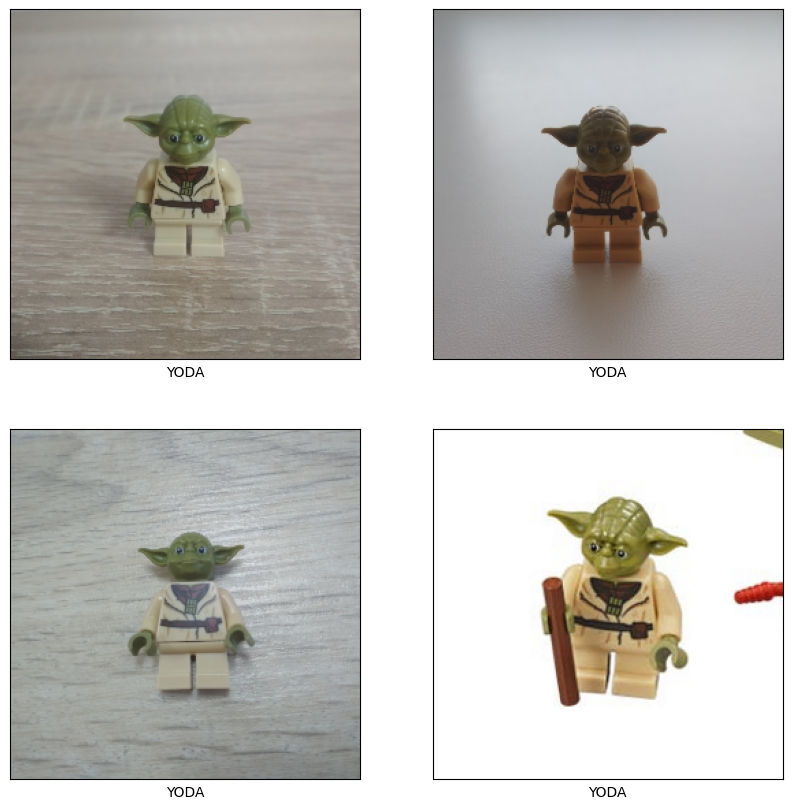

In [56]:
def show(batch, pred_labels=None):
    images, labels = batch

    plt.figure(figsize=(10, 10))
    for i in range(min(4, len(images))):
        plt.subplot(2, 2, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Convert Tensor to NumPy if needed
        img = images[i].numpy() if hasattr(images[i], "numpy") else images[i]
        plt.imshow(img)  # RGB image: no cmap needed

        label = names[int(labels[i])]
        if pred_labels is not None:
            pred = pred_labels[i].numpy() if hasattr(pred_labels[i], "numpy") else pred_labels[i]
            label += " / Pred: " + names[int(pred)]
        plt.xlabel(label)

    plt.show()
show(test_batch)

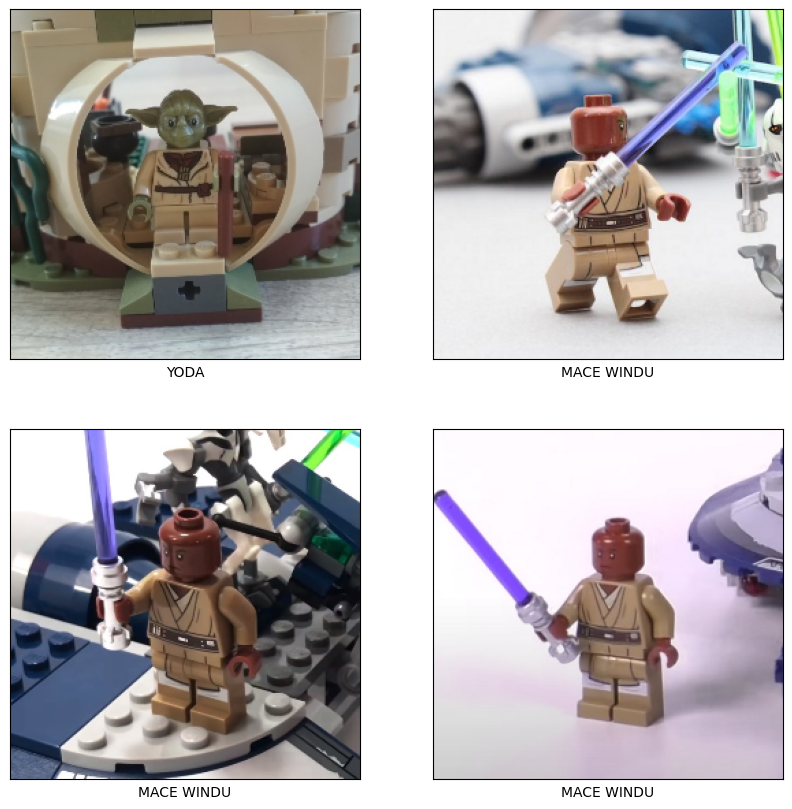

In [57]:
show(train_batch)

In [58]:
model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), strides = (1, 1), padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 64)   │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 254016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │    16,257,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,266,565 (62.05 MB)

 Trainable params: 16,266,565 (62.05 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
losses = keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer = 'adam',
    loss = losses,
    metrics = ['accuracy']
)

In [60]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 2
)

In [61]:
history = model.fit(
    train_batches,
    validation_data = val_batches,
    callbacks = [early_stopping],
    epochs = 30,
    verbose = 2
)

Epoch 1/30
13/13 - 11s - 836ms/step - accuracy: 0.2308 - loss: 4.7147 - val_accuracy: 0.1786 - val_loss: 1.7131
Epoch 2/30
13/13 - 9s - 708ms/step - accuracy: 0.3462 - loss: 1.5673 - val_accuracy: 0.4643 - val_loss: 1.2503
Epoch 3/30
13/13 - 8s - 613ms/step - accuracy: 0.4808 - loss: 1.3371 - val_accuracy: 0.7143 - val_loss: 1.0604
Epoch 4/30
13/13 - 9s - 683ms/step - accuracy: 0.6538 - loss: 0.9622 - val_accuracy: 0.7500 - val_loss: 0.8552
Epoch 5/30
13/13 - 7s - 537ms/step - accuracy: 0.8269 - loss: 0.5978 - val_accuracy: 0.8571 - val_loss: 0.5629
Epoch 6/30
13/13 - 9s - 677ms/step - accuracy: 0.9423 - loss: 0.3480 - val_accuracy: 0.7500 - val_loss: 0.5718
Epoch 7/30
13/13 - 10s - 794ms/step - accuracy: 0.8077 - loss: 0.4390 - val_accuracy: 0.8929 - val_loss: 0.7595
Epoch 8/30
13/13 - 19s - 1s/step - accuracy: 0.9615 - loss: 0.2085 - val_accuracy: 0.8571 - val_loss: 1.2603
Epoch 9/30
13/13 - 8s - 584ms/step - accuracy: 0.9423 - loss: 0.1379 - val_accuracy: 0.9286 - val_loss: 0.6644
E

In [62]:
# model.save(BASE_DIR + 'lego_model.keras')

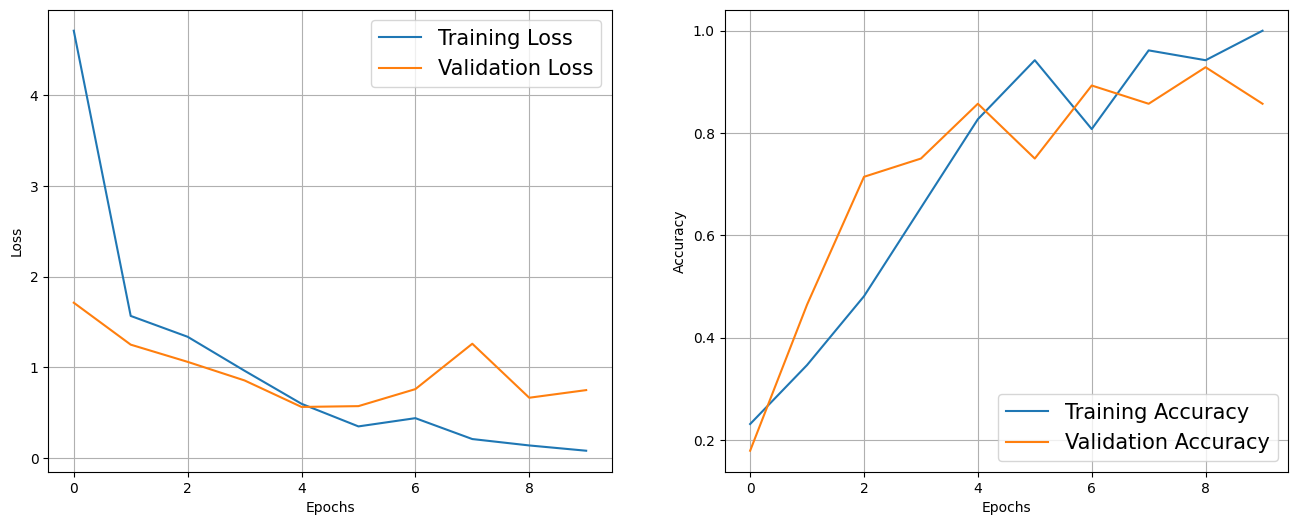

In [63]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize = 15)

plt.show()

In [64]:
model.evaluate(test_batches)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9373 - loss: 0.1544


[0.14783915877342224, 0.9473684430122375]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
[0. 0. 0. 0.]
[0 0 0 0]


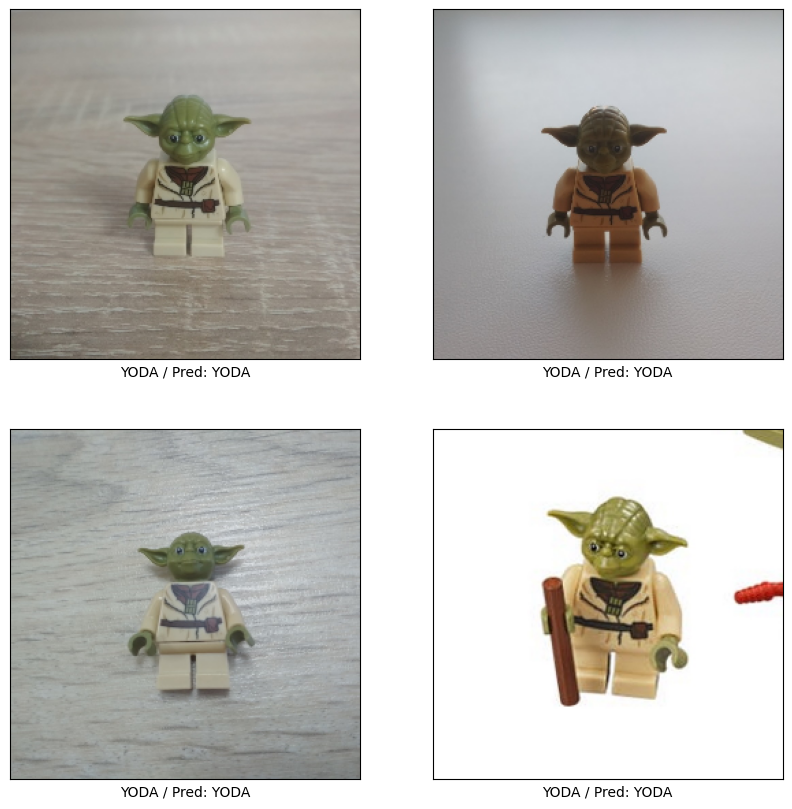

In [65]:
predictions = model.predict(test_batches)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

show(test_batches[0], labels[0:4])

**Transfer Learning**

In [66]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

<class 'keras.src.models.functional.Functional'>


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model = keras.models.Sequential()

for layer in vgg_model.layers[:-1]:
  model.add(layer)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

In [75]:
for layer in model.layers:
  layer.trainable = False

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

In [76]:
model.add(layers.Dense(5))

In [78]:

# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam()
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [79]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [82]:
# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    '/content/drive/MyDrive/star-wars_copy/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

val_batches = valid_gen.flow_from_directory(
    '/content/drive/MyDrive/star-wars_copy/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    '/content/drive/MyDrive/star-wars_copy/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 52 images belonging to 5 classes.
Found 28 images belonging to 5 classes.
Found 19 images belonging to 5 classes.


In [83]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30
13/13 - 55s - 4s/step - accuracy: 0.4038 - loss: 2.1588 - val_accuracy: 0.7143 - val_loss: 0.6283
Epoch 2/30
13/13 - 54s - 4s/step - accuracy: 0.9038 - loss: 0.2499 - val_accuracy: 0.9643 - val_loss: 0.1285
Epoch 3/30
13/13 - 53s - 4s/step - accuracy: 0.9615 - loss: 0.1322 - val_accuracy: 0.9286 - val_loss: 0.1689
Epoch 4/30
13/13 - 75s - 6s/step - accuracy: 0.9615 - loss: 0.0547 - val_accuracy: 0.8929 - val_loss: 0.3086
Epoch 5/30
13/13 - 54s - 4s/step - accuracy: 1.0000 - loss: 0.0213 - val_accuracy: 0.8929 - val_loss: 0.2626
Epoch 6/30
13/13 - 56s - 4s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8929 - val_loss: 0.2040
Epoch 7/30
13/13 - 54s - 4s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8929 - val_loss: 0.1847
Epoch 7: early stopping


In [84]:
model.evaluate(test_batches, verbose=2)

5/5 - 13s - 3s/step - accuracy: 0.9474 - loss: 0.0509


[0.05085990950465202, 0.9473684430122375]